In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import stream_data

In [3]:
stream_data.Stream()

[*********************100%***********************]  11 of 11 completed


In [4]:
df = pd.read_csv("data.csv")

In [5]:
# jpy/usd dataset (Yen Giapponese)
df_jpy = pd.read_csv("JPYUSD=X.csv")

In [6]:
df['N225'] = (df['N225']*df_jpy['Close'].mean()) 

In [7]:
#close price in USD
df.tail()

Date         AMD           BTC          ETH         Gold  \
2177  2021-12-17  137.750000  46202.144531  3879.486572  1803.800049   
2178  2021-12-18  137.750000  46848.777344  3960.860107  1803.800049   
2179  2021-12-19  137.750000  46707.015625  3922.592529  1803.800049   
2180  2021-12-20  135.800003  46880.277344  3933.844482  1793.699951   
2181  2021-12-21  144.250000  48936.613281  4020.260010  1787.900024   

             LTC      NVIDIA    Palladium       XLM       XRP        SP500  \
2177  144.338409  278.010010  1782.599976  0.255147  0.799291  4620.640137   
2178  148.801407  278.010010  1782.599976  0.255201  0.827379  4620.640137   
2179  153.077637  278.010010  1782.599976  0.253265  0.835033  4620.640137   
2180  152.628677  277.190002  1743.699951  0.257717  0.879828  4568.020020   
2181  154.927094  290.750000  1790.900024  0.267563  0.947646  4649.229980   

            N225  
2177  261.161179  
2178  261.161179  
2179  261.161179  
2180  255.599853  
2181  260.904188

In [8]:
# no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2182 non-null   object 
 1   AMD        2182 non-null   float64
 2   BTC        2182 non-null   float64
 3   ETH        2182 non-null   float64
 4   Gold       2182 non-null   float64
 5   LTC        2182 non-null   float64
 6   NVIDIA     2182 non-null   float64
 7   Palladium  2182 non-null   float64
 8   XLM        2182 non-null   float64
 9   XRP        2182 non-null   float64
 10  SP500      2182 non-null   float64
 11  N225       2182 non-null   float64
dtypes: float64(11), object(1)
memory usage: 204.7+ KB


In [9]:
df.shape

(2182, 12)

In [10]:
df.describe()

AMD           BTC          ETH         Gold          LTC  \
count  2182.000000   2182.000000  2182.000000  2182.000000  2182.000000   
mean     38.025316  12844.576488   648.702328  1454.288726    78.161795   
std      35.542085  16332.642114  1033.812120   250.653549    71.435167   
min       1.800000    364.330994     0.937124  1073.900024     2.996780   
25%      11.512500   2572.202576   116.459682  1258.224976    30.737429   
50%      23.595000   7355.754150   228.859909  1323.250000    56.205257   
75%      55.310001  11287.121094   538.540436  1729.300049   119.594013   
max     161.910004  67566.828125  4812.087402  2051.500000   386.450775   

            NVIDIA    Palladium          XLM          XRP        SP500  \
count  2182.000000  2182.000000  2182.000000  2182.000000  2182.000000   
mean     73.233184  1431.672067     0.141516     0.382881  2939.263497   
std      64.137917   690.185229     0.151739     0.394920   708.024494   
min       6.305000   469.899994     0.001444     0.005112  1829.079956   
25%      35.459999   863.512497     0.018342     0.177101  2429.090027   
50%      52.064999  1240.099976     0.080187     0.277683  2792.669922   
75%      92.612503  2038.400024     0.239247     0.484661  3268.807495   
max     333.760010  2985.399902     0.896227     3.377810  4712.020020   

              N225  
count  2182.000000  
mean    201.933227  
std      34.583648  
min     136.794327  
25%     178.636281  
50%     199.325321  
75%     214.351335  
max     280.597255

Descrizione del dataset

In [11]:
counts = []
for col in df.columns:
    na_count = df[df[col].isna()].shape[0]
    counts.append(na_count)

pd.DataFrame(counts, index=df.columns, columns=['NA'])

NA
Date        0
AMD         0
BTC         0
ETH         0
Gold        0
LTC         0
NVIDIA      0
Palladium   0
XLM         0
XRP         0
SP500       0
N225        0

Check per vedere se sono presenti dati mancanti


# Prepocessing : trasformazione del tipo di dati


In [12]:
df.dtypes

Date          object
AMD          float64
BTC          float64
ETH          float64
Gold         float64
LTC          float64
NVIDIA       float64
Palladium    float64
XLM          float64
XRP          float64
SP500        float64
N225         float64
dtype: object

In [13]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [14]:
df.dtypes

Date         datetime64[ns]
AMD                 float64
BTC                 float64
ETH                 float64
Gold                float64
LTC                 float64
NVIDIA              float64
Palladium           float64
XLM                 float64
XRP                 float64
SP500               float64
N225                float64
dtype: object

## Grafici preliminari


<AxesSubplot:>

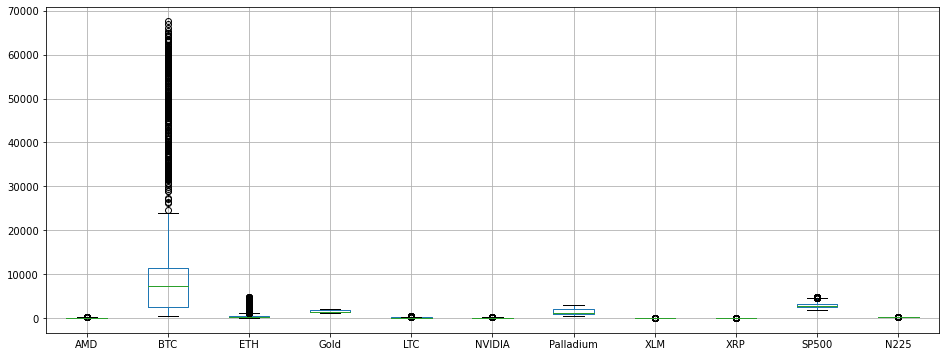

In [15]:
df.boxplot(figsize=(16,6))

In [16]:
#copia del dataset
newdf = df.copy()

In [17]:
#uso le date come index
newdf.set_index('Date', inplace=True)

In [18]:
df_cryptocurrencies = newdf[['ETH','BTC','XRP','LTC','XLM']]
df_commodities = newdf[['Palladium','BTC','Gold']]
df_financial_indexes = newdf[['BTC','N225','SP500']]
df_stock_data = newdf[['NVIDIA','BTC','AMD']]

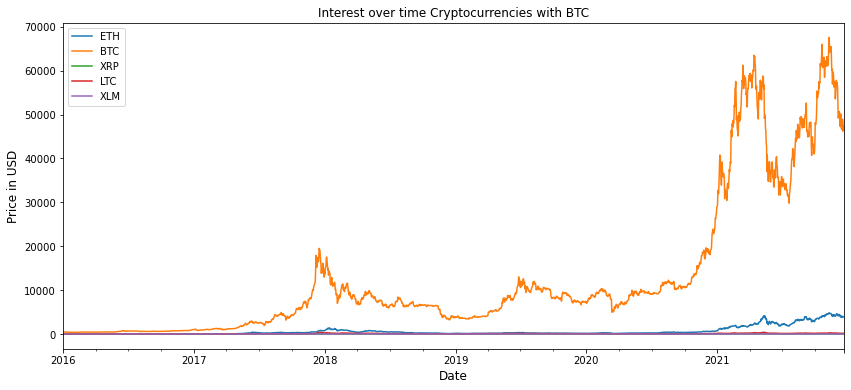

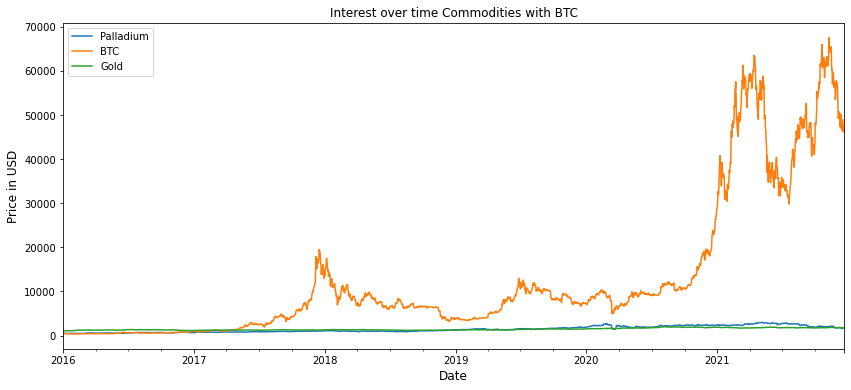

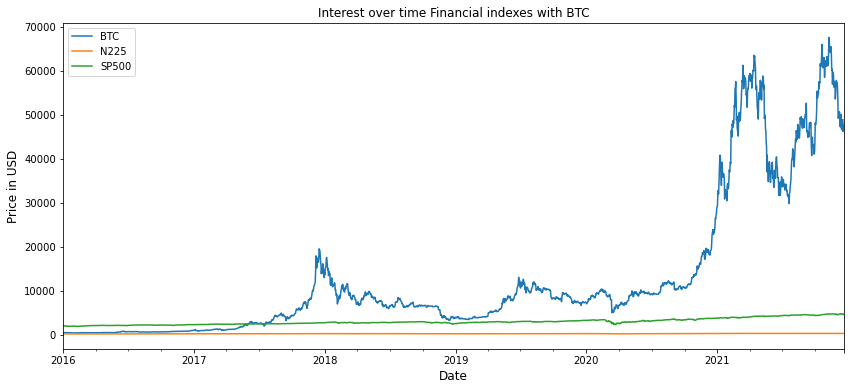

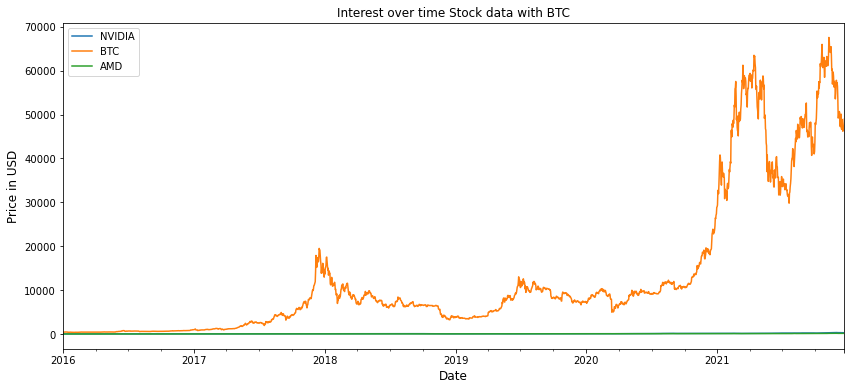

In [19]:
list1 = [df_cryptocurrencies,df_commodities,df_financial_indexes,df_stock_data]
list_name = ['Cryptocurrencies', 'Commodities', 'Financial indexes', 'Stock data']
for i in range(len(list1)):
    
    list1[i].plot(figsize=(14,6))
#df_commodities.plot(figsize=(14,6))
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price in USD', fontsize=12)
    plt.title('Interest over time '+ list_name[i] + ' with BTC');

# Indicatori tecnici

### Simple Moving Average (SMA)

Una semplice media mobile attenua la volatilità e rende più facile visualizzare l'andamento del prezzo di un titolo. Se la media mobile semplice punta verso l'alto, significa che il prezzo del titolo è in aumento. Se punta verso il basso, significa che il prezzo del titolo sta diminuendo.

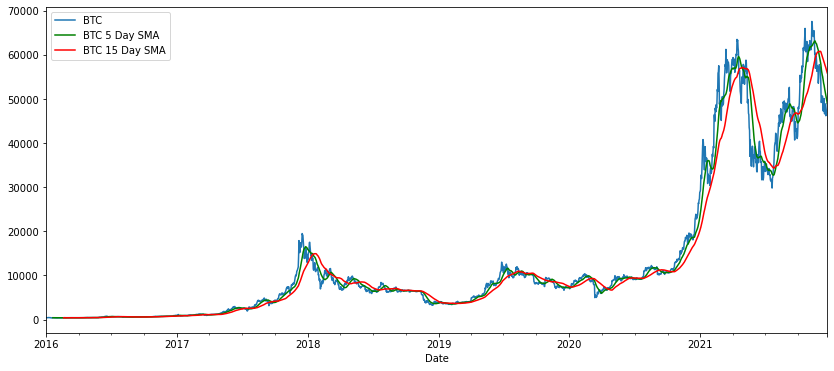

In [20]:
rolling_mean = newdf.BTC.rolling(window= 20).mean()
rolling_mean2 = newdf.BTC.rolling(window= 50).mean()
newdf.BTC.plot(figsize=(14,6),label='BTC')
rolling_mean.plot(label='BTC 5 Day SMA', color='green')
rolling_mean2.plot(label='BTC 15 Day SMA', color='red')
plt.legend(loc='upper left')
plt.show()

Un esempio di utilizzo delle medie mobili è seguire i crossover. Ad esempio, un crossover rialzista si verifica quando la SMA a breve termine supera la SMA a lungo termine. Un crossover ribassista si verifica quando la SMA a breve termine incrocia al di sotto della SMA a lungo termine.

Quando il breve termine supera il lungo termine, riceviamo un segnale di acquisto. Quando il breve termine passa al di sotto del lungo termine, riceviamo un segnale di vendita.

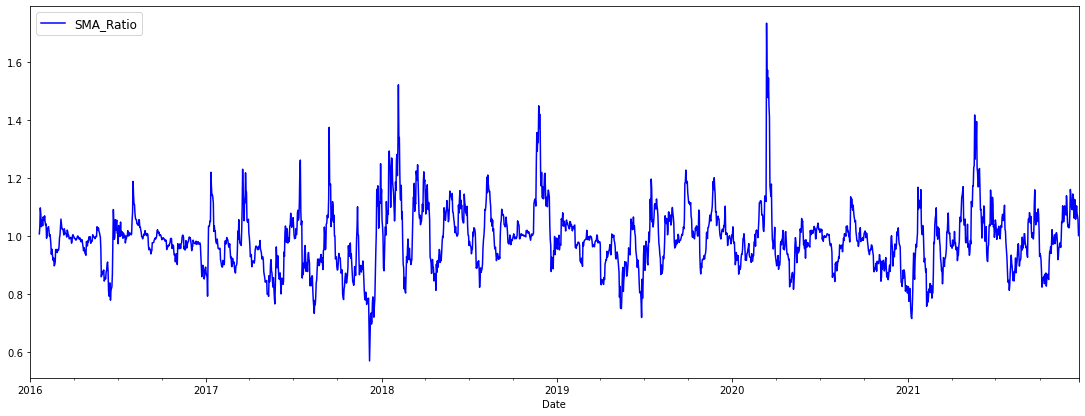

In [21]:
(rolling_mean/newdf.BTC).plot( figsize=(16,6),color = 'blue')
plt.legend(['SMA_Ratio'], ncol=3, loc = 'upper left', fontsize = 12)
plt.subplots_adjust(left=.09, bottom=.09, right=1, top=.95, wspace=.20, hspace=0)

### Exponential Moving Average (EMA)

L'EMA si concentra maggiormente sui dati recenti assegnando più peso ai nuovi dati. L'idea principale alla base dell'EMA è quella di dare la preferenza ai dati recenti rispetto ai dati precedenti. Più vecchi sono i dati, minore è il peso ad essi assegnato. Per questo motivo, l'EMA è più reattiva ai cambiamenti di tendenza rispetto alla SMA, dove a tutti i valori viene assegnato lo stesso peso

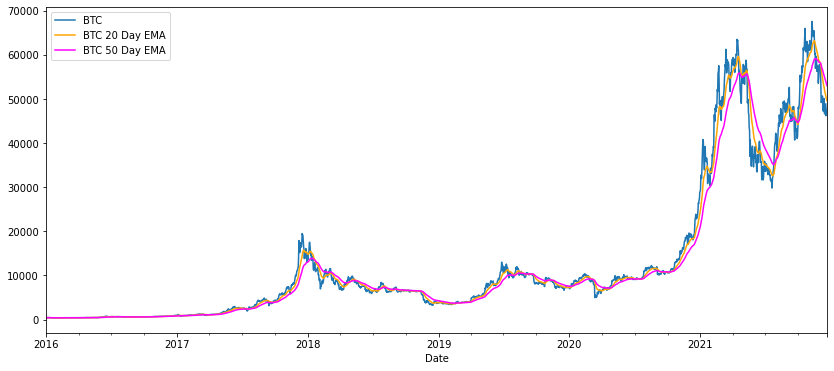

In [22]:
exp1 = newdf.BTC.ewm(span=20, adjust=False).mean()
exp2 = newdf.BTC.ewm(span=50, adjust=False).mean()
newdf.BTC.plot(figsize=(14,6),label='BTC')
exp1.plot(label='BTC 20 Day EMA', color='orange')
exp2.plot(label='BTC 50 Day EMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

### Relative Strength Index (RSI)

In [23]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

btc = newdf.copy()
btc['rsi_14'] = get_rsi(newdf['BTC'], 14)
btc = btc.dropna()
btc.head(3)

AMD         BTC       ETH         Gold      LTC  NVIDIA  \
Date                                                                   
2016-01-05  2.75  431.959991  0.950176  1078.400024  3.46967  8.2225   
2016-01-06  2.51  429.105011  0.950860  1091.900024  3.45356  7.8825   
2016-01-07  2.28  458.048004  0.942005  1107.699951  3.60414  7.5700   

             Palladium       XLM       XRP        SP500        N225     rsi_14  
Date                                                                            
2016-01-05  535.099976  0.001721  0.006044  2016.709961  168.101637  37.320691  
2016-01-06  505.049988  0.001672  0.006003  1990.260010  166.430322  26.634664  
2016-01-07  493.000000  0.001728  0.006039  1943.089966  162.551373  82.218856

In [24]:
list1 = list(newdf.columns)


In [25]:
btc = btc.drop(['ETH','XRP','LTC','XLM','Palladium','Gold','N225','SP500','NVIDIA','AMD'], axis = 1)

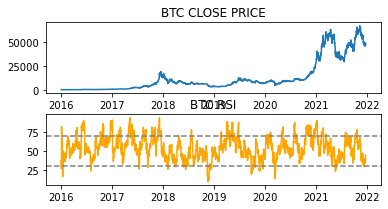

In [26]:


ax1 = plt.subplot2grid((12,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((12,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(btc['BTC'], linewidth = 1.5)
ax1.set_title('BTC CLOSE PRICE')
ax2.plot(btc['rsi_14'], color = 'orange', linewidth = 1.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('BTC RSI')
plt.show()

In [27]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30: #stato di ipervenduto
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70: #stato di ipercomprato
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(btc['BTC'], btc['rsi_14'])

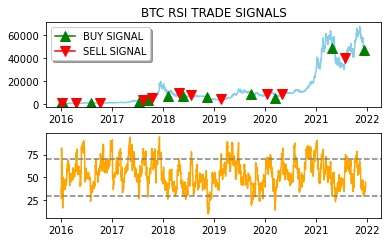

In [28]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(btc['BTC'], linewidth = 1.5, color = 'skyblue')
ax1.plot(btc.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(btc.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('BTC RSI TRADE SIGNALS')
ax2.plot(btc['rsi_14'], color = 'orange', linewidth = 1.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax1.legend(shadow=True, fancybox=True)
plt.show()

## Grafici: prendo in considerazione periodo pandemico

In [29]:
df_2020 = df[df.Date.dt.year >= 2020]

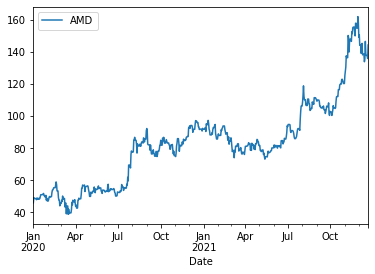

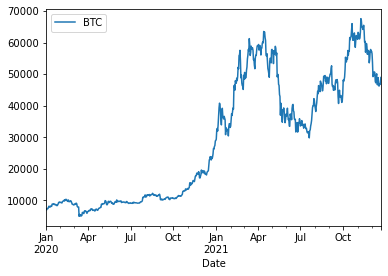

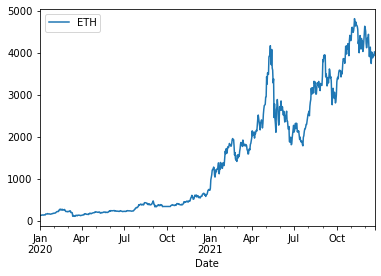

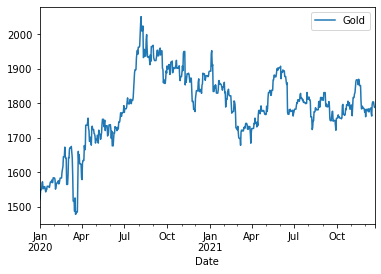

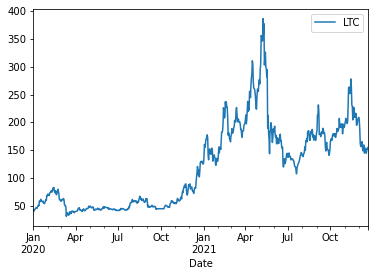

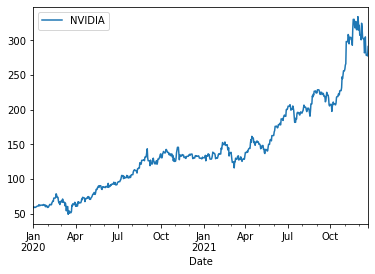

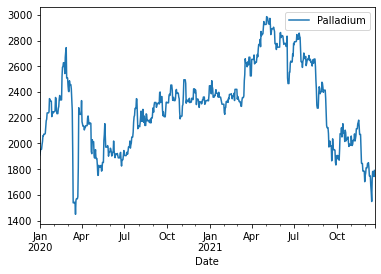

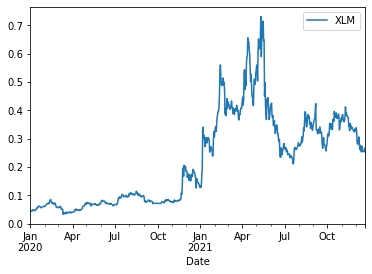

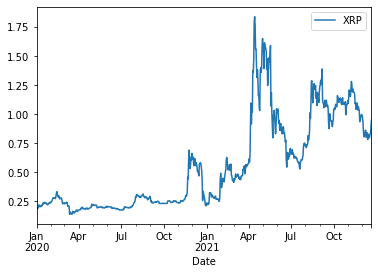

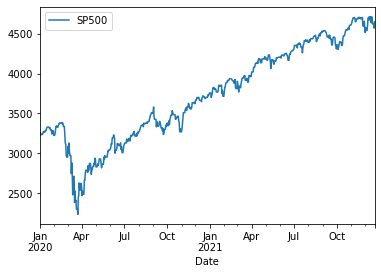

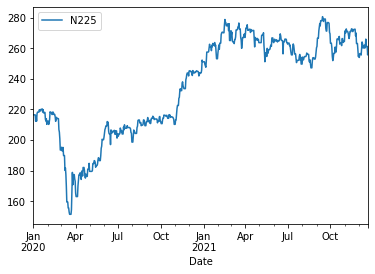

In [30]:
#take exam 2020 year
list2 = list(df_2020.columns[1:])
for i in list2:
    df_2020.plot(x='Date', y=i)

Un trend simile è riportato durante il primo anno di pandemia globale da parte di tutti gli indicatori finanziari

<AxesSubplot:xlabel='Date'>

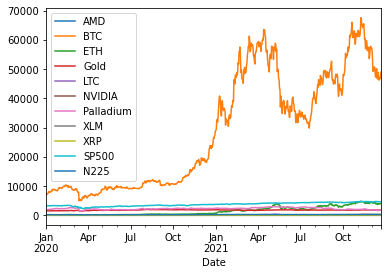

In [31]:
df_2020.plot(x='Date')

Grafico che riporta l'andamento dei vari indicatori presenti nel dataset nell' anno 2020.

## Correlazione di Pearson

In [32]:
#import seaborn as sns
#pearson correlation
#data_corr = newdf.iloc[:, :].corr()
#sns.set(rc={"figure.figsize":(14, 6)})
#sns.heatmap(data_corr, annot=True, cmap='Blues')
#plt.title("pearson correlation map", fontsize=15)



## Returns

I rendimenti nel mercato delle monete non sono altro che una variazione percentuale del prezzo.

In [33]:
#faccio una copia del dataset
df_return = newdf.copy()

In [34]:
#funzione che mi calcola (P1-P0)/P0 il ritorno rispetto al numero di righe specificate nel parametro periods
df_return = df_return.pct_change()

In [35]:
df_return = df_return.drop(df_return.index[0])


In [36]:
df_return.head()

AMD       BTC       ETH      Gold       LTC    NVIDIA  \
Date                                                                     
2016-01-02  0.000000 -0.002063 -0.011498  0.000000 -0.001944  0.000000   
2016-01-03  0.000000 -0.007907  0.037115  0.000000 -0.005451  0.000000   
2016-01-04  0.000000  0.007163 -0.017929  0.000000  0.003537  0.000000   
2016-01-05 -0.007220 -0.002611 -0.004509  0.003070 -0.007358  0.016064   
2016-01-06 -0.087273 -0.006609  0.000720  0.012519 -0.004643 -0.041350   

            Palladium       XLM       XRP     SP500      N225  
Date                                                           
2016-01-02   0.000000 -0.004005  0.018472  0.000000  0.000000  
2016-01-03   0.000000  0.001723 -0.007914  0.000000  0.000000  
2016-01-04   0.000000  0.002294 -0.009806  0.000000  0.000000  
2016-01-05  -0.014458 -0.015446  0.014434  0.002012 -0.004172  
2016-01-06  -0.056158 -0.028472 -0.006784 -0.013115 -0.009942

## Grafico dei rendimenti

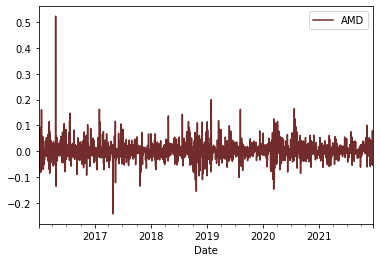

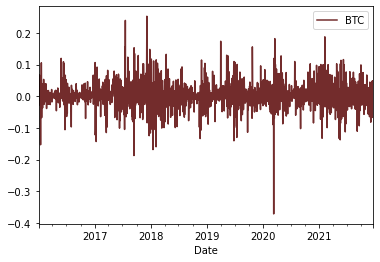

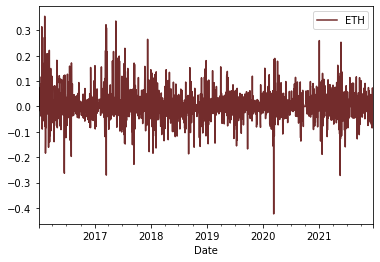

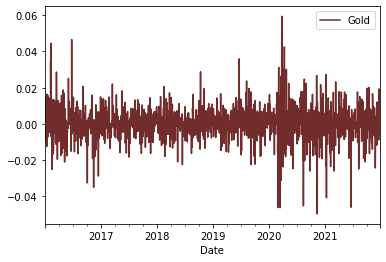

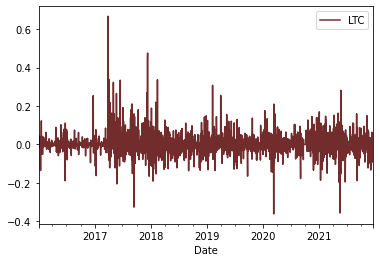

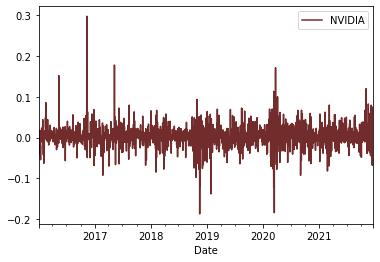

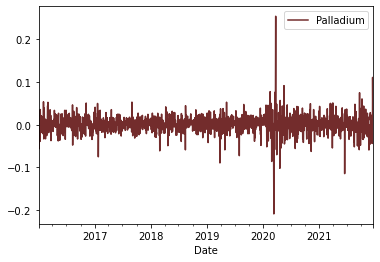

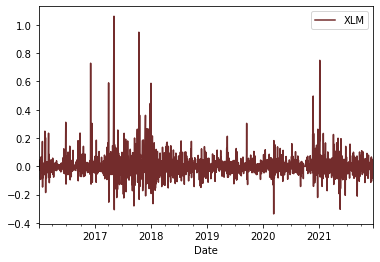

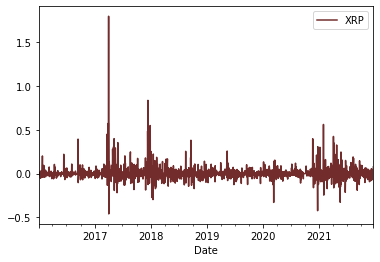

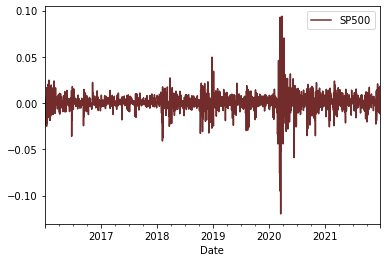

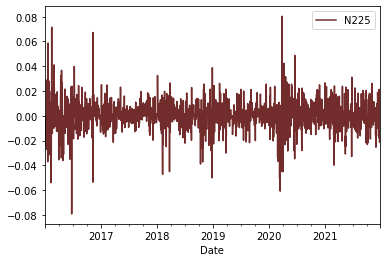

In [37]:
for i in list(df_return.columns):
    
    df_return.plot( y= i , color='#732C2C')

In [38]:

#sns.set(rc={"figure.figsize":(14, 6)})
#sns.heatmap(df_return.iloc[:, :].corr(), annot=True, cmap='Blues')
#plt.title("pearson correlation map", fontsize=15)
#valori bassi nella correlazione tra return

In [39]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.05)
            q3 = dataframe[column].quantile(0.95)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df_return)

Feature Number of Outliers
0         AMD                  3
1         BTC                  1
2         ETH                  1
3        Gold                  3
4         LTC                  5
5      NVIDIA                  5
6   Palladium                  6
7         XLM                 10
8         XRP                 17
9       SP500                 10
10       N225                  5

Numero di outliers presenti in ciascuna feature

#### Boxplot dei returns considerando anche gli outliers

<AxesSubplot:>

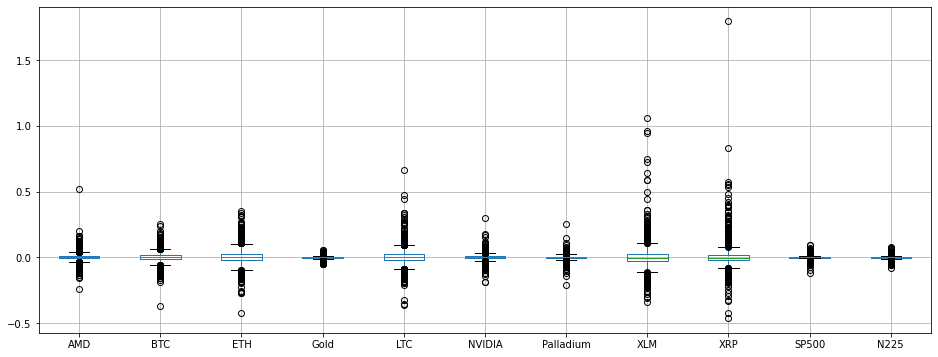

In [40]:
df_return.boxplot(figsize=(16,6))

Eliminazione degli outliers

In [41]:
#Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df_return2 = df_return.copy()
df_return2 = treat_outliers(df_return2)

In [42]:
detect_outliers(df_return2)

Feature Number of Outliers
0         AMD                  0
1         BTC                  0
2         ETH                  0
3        Gold                  0
4         LTC                  0
5      NVIDIA                  0
6   Palladium                  0
7         XLM                  0
8         XRP                  0
9       SP500                  0
10       N225                  0

#### Boxplot senza considerare gli outliers

<AxesSubplot:>

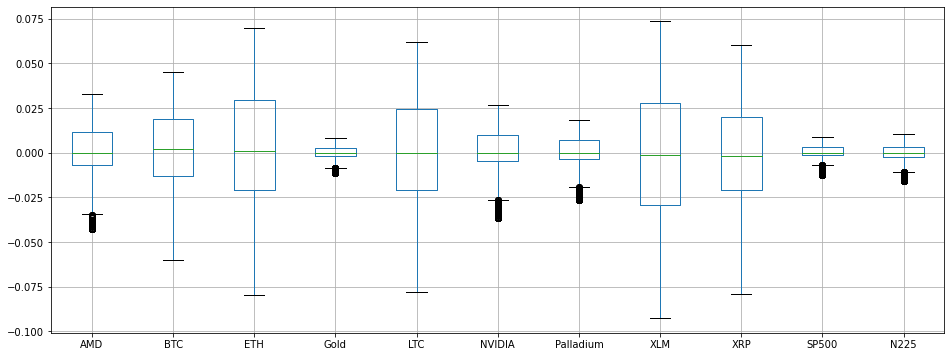

In [60]:
df_return2.boxplot(figsize=(16,6))

## Risk analysis 

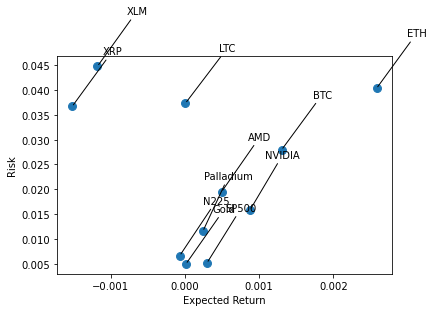

In [44]:
area=np.pi*20
plt.scatter(df_return2.mean(),df_return2.std(),s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label, x,y in zip(df_return2.columns,df_return2.mean(),df_return2.std()):
    plt.annotate(
        label,
        xy=(x,y),xytext=(50,50),
        textcoords='offset points',ha='right',va='bottom',
        arrowprops=dict(arrowstyle='-',connectionstyle='arc,rad=-0.3'))

In [45]:
#df_return2.loc['2020-01-01':]

## Risk Analysis in 2020-21

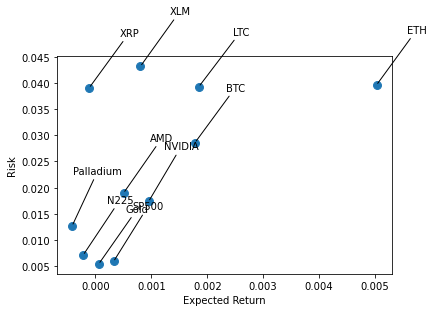

In [46]:

area=np.pi*20
plt.scatter(df_return2.loc['2020-01-01':].mean(),df_return2.loc['2020-01-01':].std(),s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')


for label, x,y in zip(df_return2.loc['2020-01-01':].columns,df_return2.loc['2020-01-01':].mean(),df_return2.loc['2020-01-01':].std()):
    plt.annotate(
        label,
        xy=(x,y),xytext=(50,50),
        textcoords='offset points',ha='right',va='bottom',
        arrowprops=dict(arrowstyle='-',connectionstyle='arc,rad=-0.3'))

## Monte Carlo Simulations

La simulazione Monte Carlo è un modello probabilistico che genera variabili casuali utilizzate in tandem con fattori economici (rendimento atteso, volatilità - nel caso di un portafoglio di fondi) per prevedere i risultati su un ampio spettro. Sebbene non sia il più accurato, il modello viene spesso utilizzato per calcolare il rischio e l'incertezza.

Utilizzeremo ora la simulazione Monte Carlo per generare una serie di rendimenti previsti di Bitcoin che ci aiuteranno a scoprire il VaR.

In [47]:
days= 252
start_price = df_return2.BTC[-1]

In [48]:

def stock_monte_carlo(start_price,days,sigma):
    price=np.zeros(days)
    price[0]=start_price
    shock=np.zeros(days)
    
    
    for x in range(1,days):
        shock[x]=np.random.normal(df_return2.BTC.tail(252).mean(),df_return2.BTC.tail(252).std())
        
        price[x]=price[x-1] + (price[x-1]*(shock[x]))
        
    return price

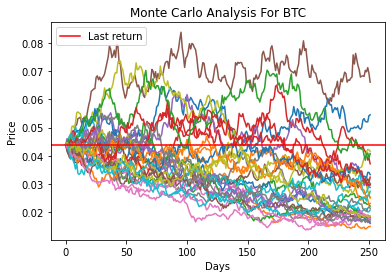

In [49]:

for run in range(30):
    plt.plot(stock_monte_carlo(start_price,days,df_return2.BTC.tail(252).std()))
plt.axhline(y = start_price, color = 'r', linestyle = '-',label="Last return")
plt.legend(loc='upper left')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis For BTC')
plt.ioff()

In [50]:
runs=1000

simulations=np.zeros(runs)

for run in range(runs):
    simulations[run]=stock_monte_carlo(start_price,days,df_return2.BTC.tail(252).std())[days-1]

In [51]:
#sono i 1000 ultimi returni delle simulazioni di Monte Carlo dopo 252 giorni
#simulations

Calculate Monte Carlo average VaR

In [52]:
Var_s=np.percentile(simulations,5)
print('Monte Carlo var: %0.4f' % Var_s)

Monte Carlo var: 0.0119


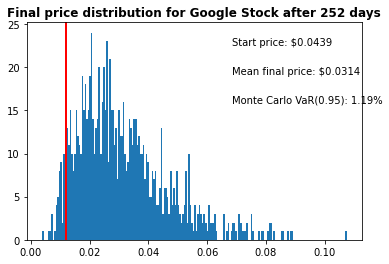

In [53]:


plt.hist(simulations,bins=200)


# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.4f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.4f" % simulations.mean())

# Variance of the price simulation(within 95% confidence interval)
plt.axvline(x= Var_s, linewidth=2, color='r')
t = 100 * Var_s
plt.figtext(0.6, 0.6, "Monte Carlo VaR(0.95): %.2f" % t+'%')





# Plot a line at the 1% quantile result



# Title
plt.title(u"Final price distribution for Google Stock after %s days" % days, weight='bold');

In [54]:
df_return2.head(2)

AMD       BTC       ETH  Gold       LTC  NVIDIA  Palladium  \
Date                                                                     
2016-01-02  0.0 -0.002063 -0.011498   0.0 -0.001944     0.0        0.0   
2016-01-03  0.0 -0.007907  0.037115   0.0 -0.005451     0.0        0.0   

                 XLM       XRP  SP500  N225  
Date                                         
2016-01-02 -0.004005  0.018472    0.0   0.0  
2016-01-03  0.001723 -0.007914    0.0   0.0

In [55]:
df_return2.shape[0]

2181

In [56]:
index_Close = df_return2.columns.get_loc("BTC")
index_Close

1

#### Save data into csv file

In [57]:
df_return2.to_csv('file2.csv', header=True, index=True)

In [58]:
newdf.to_csv('file3.csv', header=True, index=True)

In [59]:
newdf.head(3)

AMD         BTC       ETH         Gold      LTC  NVIDIA  \
Date                                                                   
2016-01-01  2.77  434.334015  0.948024  1075.099976  3.50898  8.0925   
2016-01-02  2.77  433.437988  0.937124  1075.099976  3.50216  8.0925   
2016-01-03  2.77  430.010986  0.971905  1075.099976  3.48307  8.0925   

             Palladium       XLM       XRP        SP500        N225  
Date                                                                 
2016-01-01  542.950012  0.001748  0.005955  2012.660034  168.805923  
2016-01-02  542.950012  0.001741  0.006065  2012.660034  168.805923  
2016-01-03  542.950012  0.001744  0.006017  2012.660034  168.805923